# Игра "5 Букв"
Тинькофф перезапустил игру "5 букв", в которой нужно отгадывать слова. Вам нужно набрать существительное из пяти букв, система покажет какие буквы этого слова есть в загаданном слове, на основе этой информации вы должны отгадать слово за несколько попыток.  
Для призов банк подготовил скидки, кэшбэки и др. Например, за 60 слов можно получить 50%-й кэшбэк в Ozon.
Играем в игру из приложения Тиньков банка "5 букв".  Правила игры похожи на игру Wordle.
<div>
<img src="game.jpeg" width="200"/>
</div>   
Попробуем придумать какую-нибудь стратегию для выигрыша.

Для нашей игры прочитаем список слов, которые:
* состоят из 5 букв
* не содержат символы не из алфавита (дефисы, английские буквы)
* не начинаются с заглавной буквы  

Исходный файл *nouns.csv* взят с гитхаба [https://github.com/Badestrand/russian-dictionary] (Creative Commons Attribution Share Alike 4.0)

In [1]:
words = []
with open('nouns.txt', encoding='utf-8') as file:
    words = [w.strip() for w in file.readlines()]
words.sort()
(words[:10], len(words))

(['аарон',
  'аббат',
  'абвер',
  'абзац',
  'аборт',
  'абрек',
  'абрис',
  'абхаз',
  'аванс',
  'авгур'],
 2593)

Что насчет дубликатов?

In [2]:
dwords = ([w for w in words if words.count(w)>1])
if len(set(dwords))==0:
    print("Дубликатов нет")
else:
    print(f'Найдены дубликаты: {set(dwords)}')
    words=list(set(words))

Дубликатов нет


Cоберем статистику по буквам

In [3]:
# соберем статистику по буквам
# а теперь посмотрим, на каких местах каждая буква встречается чаще
alphabet='абвгдеёжзийклмнопрстуфхцчшщъыьэюя' # буква 'ё' по правилам игры заменяется на 'е'
dict={}
wrongletters = ''
for w in words:
    for l in w:
        if l in alphabet:
            dict[l] = dict.get(l, 0) + 1
        else:
            if l not in wrongletters:
                wrongletters += l
print(f"символы не в словаре: {wrongletters}")
sorted_tuples = sorted(dict.items(), key=lambda x: x[1],reverse=True)
sorted_dict = {k: v for k, v in sorted_tuples}
mostusedletters = "".join(list(sorted_dict.keys()))
print(f"Буквы, отсортированные по степени встречаемости: {mostusedletters}")

символы не в словаре: 
Буквы, отсортированные по степени встречаемости: аокретилнсупмвбдзгьяшчыхжфйцющэъ


In [4]:
# а теперь посмотрим, на каких местах каждая буква встречается чаще
letterplaces={k: [0]*5 for k in alphabet}
for w in words:
    for l,i in zip(w,range(5)):        
        letterplaces[l][i] += 1

# letterplaces = {k:[l/sum(letterplaces[k]) for l in letterplaces[k]] for k in letterplaces}  # нормируем места по буквам
# sum([sum(letterplaces[k]) for k in letterplaces]) - len(letterplaces) # =0

In [5]:
letterplaces

{'а': [97, 539, 129, 262, 643],
 'б': [176, 43, 102, 32, 17],
 'в': [150, 45, 96, 41, 41],
 'г': [118, 17, 63, 37, 34],
 'д': [103, 14, 104, 51, 75],
 'е': [10, 301, 134, 288, 43],
 'ё': [0, 0, 0, 0, 0],
 'ж': [41, 4, 48, 17, 20],
 'з': [91, 32, 80, 40, 32],
 'и': [37, 215, 89, 249, 68],
 'й': [0, 1, 38, 8, 50],
 'к': [239, 53, 99, 267, 281],
 'л': [110, 109, 239, 117, 72],
 'м': [140, 33, 120, 52, 51],
 'н': [97, 39, 155, 146, 173],
 'о': [155, 404, 97, 375, 101],
 'п': [235, 40, 93, 23, 22],
 'р': [109, 167, 296, 95, 162],
 'с': [245, 45, 133, 65, 104],
 'т': [130, 97, 168, 92, 183],
 'у': [41, 236, 47, 112, 4],
 'ф': [53, 7, 25, 10, 16],
 'х': [47, 9, 40, 21, 30],
 'ц': [11, 1, 11, 17, 49],
 'ч': [48, 4, 63, 20, 26],
 'ш': [73, 4, 53, 22, 19],
 'щ': [10, 3, 10, 6, 0],
 'ъ': [0, 2, 2, 0, 0],
 'ы': [0, 72, 17, 29, 31],
 'ь': [0, 3, 6, 53, 141],
 'э': [13, 6, 3, 0, 1],
 'ю': [4, 20, 15, 15, 1],
 'я': [10, 28, 18, 31, 103]}

Для удобства объявим функцию подсчета "рейтинга" слова. Чем больше в слове часто встречающихся букв, тем лучше. Одинаковые буквы считаются за одну.

In [6]:
def score(w, ignore='', checkplace=True):
    """
    ignore     : строка с метками для каждой буквы с слове
    checkplace : при подсчете рейтинга учитывается место буквы. Например встречаемость буквы й в зависимости от места: [0, 1, 38, 8, 50]
    """
    if ignore == '': ignore = '_'*len(w)
    s=0
    for i in range(len(w)):
        if ignore[i] not in alphabet: # вместо буквы находится символ, значит буква учавствует в подсчете
            if not checkplace:
                s += sorted_dict[w[i]]//w.count(w[i])
            else:
                s += letterplaces[w[i]][i]//w.count(w[i])
    return s


(score('попка'), score('попка','_о_ка'), (letterplaces['п'][0] + letterplaces['п'][2]) // 2, sum(letterplaces['п'])//2, sorted_dict['п']//2) # 1477, 163=163, 206=206
 

(1477, 163, 164, 206, 206)

Теперь можно посчитать рейтинг всех слов и найти слова с самыми используемыми буквами

In [7]:
scorelist=[[w, score(w)] for w in words]
sorted(scorelist,key=lambda x: x[1],reverse=True)[:10]

[['порка', 1845],
 ['солка', 1798],
 ['полка', 1788],
 ['перка', 1742],
 ['горка', 1728],
 ['сотка', 1727],
 ['парок', 1726],
 ['норка', 1707],
 ['сопка', 1652],
 ['мерка', 1647]]

Начинать игру надо со слова "порка". А если бы местоположение букв не учитывалось, это был бы "коран" или "норка". Ну и ради интереса выведем список 10 самых неудачных для начала игры слов.

In [8]:
sorted(scorelist,key=lambda x: x[1],reverse=True)[-10:]

[['изгиб', 254],
 ['уксус', 247],
 ['хиппи', 245],
 ['овощи', 244],
 ['извив', 242],
 ['рэгги', 232],
 ['уздцы', 225],
 ['дзюдо', 224],
 ['жмыхи', 180],
 ['имидж', 166]]

Осталось объявить несколько вспомогательных функций

In [9]:
# проверка слова, как это присходит в игре
def checkword(rightword, testword):
    result=''
    for rl, tl in zip(rightword, testword):
        if tl not in rightword:
            result = result + '-'
        else:
            if tl==rl:
                result = result + '+'
            else:
                result = result + '*'
    return result

print(checkword('крона', 'коран'))

# разбор результата проверки с записью в соответствующие переменные
def scanresults(testword, result, wrongletters='', wrongplaces={}, rightplaces=''):
    if rightplaces=='': rightplaces = '_' * len(testword)
    for r,i in zip(result, range(len(testword))):
        # print (r,i)
        l = testword[i]
        if (r=='-'):
            wrongletters = ''.join(set(wrongletters) | set(l))
        elif (r=='*'):
            wrongplaces[l] = wrongplaces.get(l,[]) + [i]
        else:
            t = list(rightplaces)
            t[i] = l
            rightplaces = ''.join(t)
    return (wrongletters, wrongplaces, rightplaces)

print(scanresults('порка','-+-*-'))
print(scanresults('колея','*+-+-','пра', {'к': [3]}, '_о___'))

+****
('апр', {'к': [3]}, '_о___')
('яплар', {'к': [3, 0]}, '_о_е_')


In [17]:
# вывод списка слов, удовлетворяющих условиям
def predictwords(wrongletters, wrongplaces, rightplaces, wordsarray):
    goodwords = []
    for w in wordsarray:
        badwordflag = False
        
        # 1) в слове должны быть найденные буквы в нужных местах
        for i in range(len(rightplaces)):
            if (rightplaces[i] != '_') & (rightplaces[i] != w[i]):
                badwordflag = True
                break
        if badwordflag: continue
        
        # 2) в слове не должно быть отсутствующих букв
        for l in w:
            if l in wrongletters:
                badwordflag = True
                break
        if badwordflag: continue
        
        # 3) в слове должны быть неправильно расположенные буквы
        # 4) в слове неправильно расположенные буквы не должны быть на неправильных местах
        for l in list(wrongplaces.keys()):
            if l not in w: # неправильно расположенные буквы должны быть в слове (странно, да?)
                badwordflag = True
                break
            else:
                for i in range(len(w)):
                    if (l == w[i]) & (i in wrongplaces[l]): # если место буквы в слове есть в списке "плохих" мест
                        badwordflag = True
                        break
        if badwordflag: continue
        
        # переехало в цикл к условию 3)
        # for l in list(wrongplaces.keys()):
        #     if l not in w:
        #         badwordflag = True
        #         break
        # if badwordflag: continue
        goodwords += [w]
    return goodwords    

Посчитаем, сколько нужно ходов для угадывания каждого слова. Объявим функцию, которая делает одну итерацию игры.

In [20]:
def oneturn(secret, tryword, wrongletters='', wrongplaces={}, rightplaces='', checkplace=True):
    # проверяем слово, разбираем результат
    (wrongletters, wrongplaces, rightplaces) = scanresults(tryword, checkword(secret, tryword), wrongletters, wrongplaces, rightplaces)
    # ищем слова, подходящие по условиям
    nextwords = predictwords(wrongletters, wrongplaces, rightplaces, words)
    if(len(nextwords)==1):
        return ('', wrongletters, wrongplaces, rightplaces)
    else:
        # подсчитаем рейтинг найденных слов
        scorelist=[[w, score(w, rightplaces, checkplace)] for w in nextwords]
        newwords=sorted(scorelist,key=lambda x: x[1],reverse=True)
        return(newwords[0][0], wrongletters, wrongplaces, rightplaces) # вернем слово с самым большым рейтингом

Погнали! Сначала посчитаем ходы с учетом местоположения букв в слове (слова с буквами, расопложенными на "популярных" для этой буквы местах оцениваются выше)

In [22]:
%%time
turnswithcheckplace=[]
for w in words:
    wrongletters=''; wrongplaces={}; rightplaces=''
    newword='порка'
    counter=0
    while newword != '':
        counter+=1
        if counter>10: break
        (newword, wrongletters, wrongplaces, rightplaces) = oneturn(w, newword, wrongletters, wrongplaces, rightplaces, True)
    turnswithcheckplace += [counter]
#         print(f'Следущее слово: {newword}')

len(turnswithcheckplace)

CPU times: total: 12.1 s
Wall time: 12.1 s


2594

4,88 с на Intel Core i7 870 @2.93Ggz  
42,2 с на Phenom II X4 960T @3Ggz - какая-то ошибка в установленном питоне, не может быть такая разница  
12,1 с на Intel Core i5-12400 2.50 GHz - тут тоже, похоже, что-то не так

А теперь без учета местоположения букв

In [24]:
%%time
turnswithoutcheckplace=[]
for w in words:
    wrongletters=''; wrongplaces={}; rightplaces=''
    newword='порка'
    counter=0
    while newword != '':
        counter+=1
        if counter>10: break
        (newword, wrongletters, wrongplaces, rightplaces) = oneturn(w, newword, wrongletters, wrongplaces, rightplaces, False)
    turnswithoutcheckplace += [counter]
#         print(f'Следущее слово: {newword}')

len(turnswithcheckplace)

CPU times: total: 12.5 s
Wall time: 12.4 s


2594

4,72 с на Intel Core i7 870 @2.93Ggz  
43,5 с на Phenom II X4 960T @3Ggz

Попробуем использовать pandas, seaborn и построим наглядные гистограммы

C:\Users\user\miniconda3\envs\jupyterenv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\user\miniconda3\envs\jupyterenv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\user\miniconda3\envs\jupyterenv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\user\miniconda3\envs\jupyterenv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isin

<Axes: xlabel='turns', ylabel='count'>

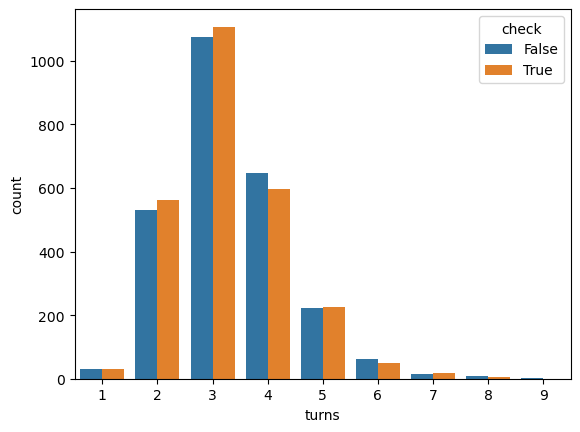

In [26]:
# import numpy as np
import pandas as pd
# import matplotlib.pyplot as plt
import seaborn as sns

# соберем датафрейм
df = pd.DataFrame({ 'turns': turnswithoutcheckplace + turnswithcheckplace, 
                    'check': [False]*len(words) + [True]*len(words)})

# две гистограммы рядом
# _, axes = plt.subplots(1, 2, sharey=True, figsize=(15, 5))
# axes[0].set_title(f"withoutcheckplace (mean={statistics.mean(turnswithoutcheckplace)})")
# axes[1].set_title(f"withcheckplace (mean={statistics.mean(turnswithcheckplace)})")
# sns.histplot(turnswithoutcheckplace, ax=axes[0])
# sns.histplot(turnswithcheckplace, ax=axes[1])

# слишком тонкие прямоугольники
# sns.histplot(x='turns', data=df, hue='check',alpha=0.5, multiple='dodge') 

# красиво, но без подписей
# plt.hist([turnswithoutcheckplace, turnswithcheckplace]);

sns.countplot(x='turns',hue='check',data=df)


Выводы, которые можно сделать из графика:
1) Внезапно, учет местоположения буквы даёт небольшой выигрыш в числе попыток.  
2) Есть такие слова, которые не отгадать за 6 ходов, используя выбранную стратегию. Найдем их

In [27]:
for i in range(len(words)):
    if (turnswithoutcheckplace[i]>6) | (turnswithcheckplace[i]>6):
        print(f"{words[i]}: {turnswithoutcheckplace[i]} {turnswithcheckplace[i]}")

бабка: 8 6
байка: 8 6
башка: 8 5
бобок: 7 5
божок: 7 5
гайка: 9 5
давка: 7 5
дачка: 7 6
дудка: 5 8
дужка: 6 8
душка: 6 7
жесть: 8 7
жучка: 7 6
заика: 5 7
зайка: 5 7
качка: 5 7
кашка: 5 7
любка: 7 2
лёжка: 7 6
мойка: 6 7
мошка: 5 7
тесть: 7 6
тётка: 7 7
фишка: 6 7
чайка: 9 8
чашка: 8 8
честь: 8 7
чижик: 5 7
чуйка: 7 7
чушка: 7 7
чёлка: 7 7
шавка: 7 5
шайка: 8 8
шашка: 8 8
шизик: 5 7
шишка: 6 7
щёлка: 7 7
щётка: 7 7


Самое трудное слово для обоих методов расчета рейтинга: "чайка"

In [28]:
(len([[words[i],t] for t, i in zip(turnswithoutcheckplace,range(len(turnswithoutcheckplace))) if t > 6]),
len([[words[i],t] for t, i in zip(turnswithcheckplace,range(len(turnswithoutcheckplace))) if t > 6]))

(25, 25)

Количество слов, которые не отгадываются за 6 ходов слов, одинаковое для обоих способов расчета рейтинга.  
Судя по гистограмме, есть слова, которые угадываются на второй ход. Посмотрим на них.

In [29]:
print([words[i] for t, i in zip(turnswithcheckplace,range(len(turnswithoutcheckplace))) if t == 1])

['бурки', 'капер', 'капор', 'кобра', 'комар', 'копна', 'копра', 'копёр', 'коран', 'крепь', 'крупа', 'нерпа', 'осока', 'парик', 'парок', 'паром', 'пивко', 'пикша', 'пирог', 'показ', 'покер', 'порка', 'порок', 'порча', 'право', 'пункт', 'репка', 'серко', 'скрап', 'толпа', 'укроп']


Посмотрим, сколько ходов нужно сделать, что бы угадать слово "чайка"

In [31]:
tryword = 'порка'
secret = 'чайка'
wrongletters=''; wrongplaces={}; rightplaces=''
i = 0
while i < 10:
    i += 1
    checkresult = checkword(secret, tryword)
    (wrongletters, wrongplaces, rightplaces) = scanresults(tryword, checkresult, wrongletters, wrongplaces, rightplaces)
    nextwords = predictwords(wrongletters, wrongplaces, rightplaces, words)
    print( (tryword, checkresult,rightplaces,len(nextwords)) )
    if(len(nextwords)==1):
        print(nextwords)
        break
    else:
        scorelist=[[w, score(w, rightplaces)] for w in nextwords]
        newwords=sorted(scorelist,key=lambda x: x[1],reverse=True)
        tryword=newwords[0][0]


('порка', '---++', '___ка', 138)
('белка', '---++', '___ка', 79)
('самка', '-+-++', '_а_ка', 22)
('ватка', '-+-++', '_а_ка', 14)
('ганка', '-+-++', '_а_ка', 10)
('кадка', '*+-++', '_а_ка', 6)
('заика', '-+-++', '_а_ка', 4)
('шайка', '-++++', '_айка', 1)
['чайка']


А теперь забубеним мега-функцию, которая на основании предыдущих попыток предлагает новое слово

In [32]:
def predictnextword(attempts):
    wrongletters = ''
    wrongplaces = {}
    rightplaces = ''

    # разберем попытки   
    for tryword, result in attempts:
        wrongletters, wrongplaces, rightplaces = scanresults(tryword, result, wrongletters, wrongplaces, rightplaces)
    
    nextwords = predictwords(wrongletters, wrongplaces, rightplaces, words)
    scorelist=[[w, score(w, rightplaces)] for w in nextwords]
    newwords=sorted(scorelist, key=lambda x: x[1], reverse=True)
    return f"{min(10,len(newwords))} из {len(newwords)}:", newwords[:10]

In [33]:
predictnextword([['порка','---++'],['белка','---++'],['самка','-+-++'],['ватка','-+-++'],['ганка','-+-++'],['кадка','*+-++']])   

('6 из 6:',
 [['заика', 180],
  ['зайка', 129],
  ['шайка', 111],
  ['чашка', 101],
  ['чайка', 86],
  ['шашка', 62]])